# Import

In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.utils.data as dset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# import scipy.io
from PIL import Image
from tqdm import tqdm

# Initail

In [99]:
# torch.set_default_tensor_type(torch.DoubleTensor)
batch = 128 # Max:128
T = 1
N = 1000
dt = T/N
epoch = 50
DOWNLOAD_MNIST = "Ture"
save_name = "DDPM_example"
device_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)
# device = torch.device("cpu")
print(device)

cuda


## U-net model

In [3]:
class DoubleConv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.GroupNorm(1, out_c), #equivalent with LayerNorm
        # nn.BatchNorm2d(out_c), # 取平均，比較不會Overfitting
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.GroupNorm(1, out_c), #equivalent with LayerNorm
        # nn.BatchNorm2d(out_c), # 取平均，比較不會Overfitting
        nn.ReLU()
    )
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    return x

class Down(nn.Module):
  def __init__(self, in_c, out_c, emb_dim=128):
    super().__init__()
    self.down = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_c,out_c),
    )

    self.emb_layer = nn.Sequential(
        nn.ReLU(),
        nn.Linear(emb_dim, out_c),
    )

  def forward(self, x, t):
    x = self.down(x)
    #擴充兩個dimension，然後使用repeat填滿成和圖片相同(如同numpy.tile)
    t_emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1]) 
    return x + t_emb

class Up(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=128):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_c,out_c)
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class Unet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=128):
        super().__init__()
        # self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64) #(b,3,64,64) -> (b,64,64,64)

        self.down1 = Down(64, 128) #(b,64,64,64) -> (b,128,32,32)
        self.sa1 = SelfAttention(128, 16) #(b,128,32,32) -> (b,128,32,32)
        self.down2 = Down(128, 256) #(b,128,32,32) -> (b,256,16,16)
        self.sa2 = SelfAttention(256, 8) #(b,256,16,16) -> (b,256,16,16)
        self.down3 = Down(256, 256) #(b,256,16,16) -> (b,256,8,8)
        self.sa3 = SelfAttention(256, 4) #(b,256,8,8) -> (b,256,8,8)

        self.bot1 = DoubleConv(256, 512) #(b,256,8,8) -> (b,512,8,8)
        self.bot2 = DoubleConv(512, 512) #(b,512,8,8) -> (b,512,8,8)
        self.bot3 = DoubleConv(512, 256) #(b,512,8,8) -> (b,256,8,8)

        self.up1 = Up(512, 128) #(b,512,8,8) -> (b,128,16,16) because the skip_x
        self.sa4 = SelfAttention(128, 8) #(b,128,16,16) -> (b,128,16,16)
        self.up2 = Up(256, 64) #(b,256,16,16) -> (b,64,32,32)
        self.sa5 = SelfAttention(64, 16) #(b,64,32,32) -> (b,64,32,32)
        self.up3 = Up(128, 64) #(b,128,32,32) -> (b,64,64,64)
        self.sa6 = SelfAttention(64, 32) #(b,64,64,64) -> (b,64,64,64)

        self.outc = nn.Conv2d(64, c_out, kernel_size=1) #(b,64,64,64) -> (b,3,64,64)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
         10000
         ** (torch.arange(0, channels, 2, device=t.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        # (bs,) -> (bs, time_dim) 
        t = t.unsqueeze(-1).type(torch.float)
        # t = t.unsqueeze(-1).type(torch.double)
        t = self.pos_encoding(t, self.time_dim)
        x1 = self.inc(x)
        
        #Down
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        #Bottle neck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        #Up
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)

        #Output
        output = self.outc(x)
        return output

## Loading Data and Data Preprocessing

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,) ,(0.5,)),    
])

trainset = torchvision.datasets.MNIST(
    root = 'dataset/mnist',
    train = True,
    transform = data_transform, #改成torch可讀
    download = DOWNLOAD_MNIST,
)

trainLoader = dset.DataLoader(trainset, batch_size = batch, shuffle=True, num_workers = 0)

# Training

In [5]:
# like DDPM
beta = torch.linspace(0.0001, 0.02, N)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

In [100]:
eps_theta = Unet().to(device)
optimizer = torch.optim.Adam(eps_theta.parameters(), lr=0.0001)
loss_func = nn.MSELoss()
loss_set = []
batch_loss = []

pbar = tqdm(range(epoch))
for ep in pbar:
    # for ep in range(epoch):
    for X_data, _ in trainLoader:
        # with torch.autocast(device_type=device_str, dtype=torch.bfloat16):

        X_data = X_data.to(device)

        time = (torch.randint(N, size=(X_data.shape[0],)))
        # forward of DDPM
        noise = torch.randn_like(X_data)
        Xt = alpha_bar[time].sqrt()[:, None, None, None].to(device) * X_data \
             + (1 - alpha_bar[time]).sqrt()[:, None, None, None].to(device) * noise

        prediction = eps_theta(Xt, time.to(device))  # 餵給net吃訓練數據x, 輸出預測值
        loss = loss_func(prediction, noise)
        # # 訓練網路三個最主要步驟
        optimizer.zero_grad()  # 梯度清0
        loss.backward()  # 誤差反向傳導
        optimizer.step()  # 神經網路參數更新
        pbar.set_description('Loss: {}'.format(loss.item()))  # 更新pbar
        # print('Loss{}: {}'.format(loss.item()))
        # lr = 8e-5 if loss<0.02 else 1e-3
        loss_set.append(loss.item())

Loss: 0.009700722992420197: 100%|██████████| 50/50 [32:59<00:00, 39.59s/it] 


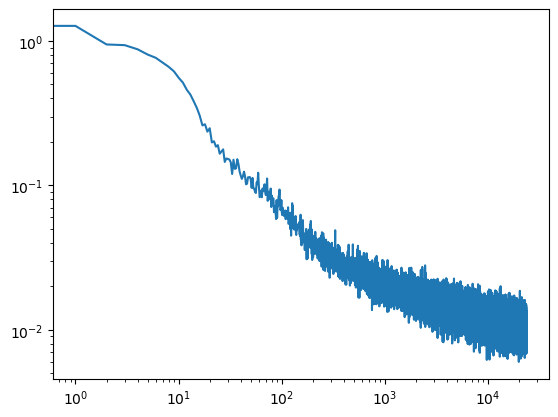

In [101]:
### Save trained model and loss figure

iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")

In [102]:
try:
    checkpoint
except NameError:
    epoch_last = 0
else:
    epoch_last = checkpoint["epoch"]
torch.save({
    'epoch': epoch_last + epoch,
    'model_state_dict': eps_theta.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_set': loss_set,
    # 'model': eps_theta,
    },  f"weights/DDPM_example.pt")
iteration = np.arange(len(loss_set))
fig = plt.figure()
plt.loglog(iteration, loss_set, "-")
plt.savefig(f"DDPM_example.png")
plt.close()

# Sampling

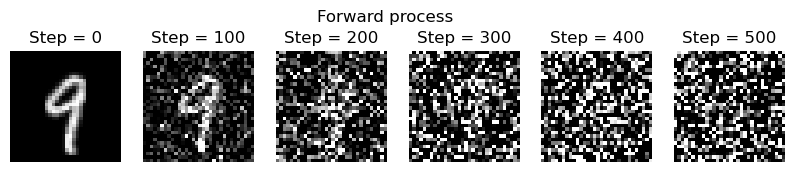

In [95]:
trainLoader = dset.DataLoader(trainset, batch_size=batch, shuffle=True)
x_test = next(iter(trainLoader))[0]
x_test_set = []
x_test_set.append(x_test)
for i in range(N):
    noise = torch.randn_like(x_test)
    x_test_set.append(alpha_bar[i].sqrt()*x_test + (1 - alpha_bar[i]).sqrt() * noise)


# x_temp = x.to(device="cpu", dtype=torch.float32).numpy().transpose((0, 2, 3, 1))  # [0][999]
#     x_temp = np.clip(x_temp, 0.0, 1.0)
num_fig = 5
steps = int(N/10)

fig = plt.figure(figsize=(10, 2))
fig.suptitle("Forward process")
# fig.suptitle("Forward process"+r"$\longrightarrow$")
# fig.text(x = 0, y = -0.1, s = "Backward process"+r"$\longleftarrow$", transform = ax.transData)

for j in range(num_fig+1):
    plt.subplot(1, num_fig+1, j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
    plt.title('Step = {}'.format(j*steps))   #第一幅图片标题
    plt.imshow(np.clip(x_test_set[j*steps][0].numpy().transpose((1, 2, 0)), 0.0, 1.0), cmap = "gray")      #绘制第一幅图片
    plt.axis("off")


In [7]:
# # Import trained model 
# save_name = "example_sm_1"
# f_theta = Unet().to(device)
# checkpoint = torch.load(f"weights/eps_theta_{save_name}.pt", weights_only=False)
# f_theta.load_state_dict(checkpoint['model_state_dict'])
# f_theta = f_theta.eval()
# X_data, _ = next(iter(trainLoader))
# # results =[]

In [109]:
# X_T = torch.randn(4, 1, 28, 28).to(device)
X_data, _ = next(iter(trainLoader))
X_data = torch.Tensor(X_data).to(device)
# X_0, _ = next(iter(trainLoader))
# X_data = torch.Tensor(X_data).to(device)
with torch.no_grad() :

    x = torch.randn_like(X_data, device = device)
    x_resize = transforms.Resize((28, 28))(x)
    x_motion = x_resize.unsqueeze(-1)
    
    ### Setting exact score function
    score_exact = lambda x, t: -(x - mu_t_list[t]*X_data ) / sigma_t_list[t]**2
    eps_exact   = lambda x, t: -sigma_t_list[t] * score_exact(x,t) #-beta*score_exact(x,t)
    
    ### backward process
    for i in range(N, 1, -1):
        idx = torch.ones(len(x)).to(device) * (i) 
        prediction = eps_theta(x, idx)
        
        x = (x - (1 - alpha[i - 1]) / torch.sqrt(1 - alpha_bar[i - 1]) * prediction.squeeze(-1))\
            / torch.sqrt(alpha[i - 1]) + ((1 - alpha[i - 1]) * (1 - alpha_bar[i - 2]) \
            / (1 - alpha_bar[i - 1])).sqrt() * torch.randn_like(x, device=device)
        x_resize = transforms.Resize((28, 28))(x)
        x_motion = torch.hstack([x_motion, x_resize.unsqueeze(-1)])
    
    idx = torch.ones(len(x)).to(device)
    prediction = eps_theta(x, idx)
    # x = (1+beta[i-1]*dt/2)*x - beta[i-1]*dt*prediction.squeeze(-1)/ sigma_t_list[i-1]

    
    ### Exact reverse
    x = (x - (1 - alpha[i - 1]) / torch.sqrt(1 - alpha_bar[i - 1]) * prediction.squeeze(-1))\
            / torch.sqrt(alpha[i - 1])
        
    x = transforms.Resize((28, 28))(x)
    x_motion = torch.hstack([x_motion, x.unsqueeze(-1)])
    
    # Print final mean and std of x
    print(torch.mean(x).item(), torch.std(x).item())
    # Print shape of x_motion
    print(x_motion.shape)

0.11551973223686218 0.25489431619644165
torch.Size([128, 1001, 28, 28, 1])


## Plot figure 

In [110]:
x = x.cpu().numpy()  # From GPU to CPU
x_motion = x_motion.cpu().numpy()

In [111]:
x.shape

(128, 1, 28, 28)

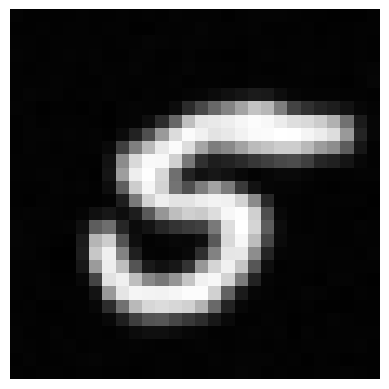

In [112]:
# # Plot one figure
# plt.imshow(x[3][-1], cmap = 'gray')
plt.imshow(x_motion[3][-1], cmap = 'gray')
plt.axis("off")
plt.show()

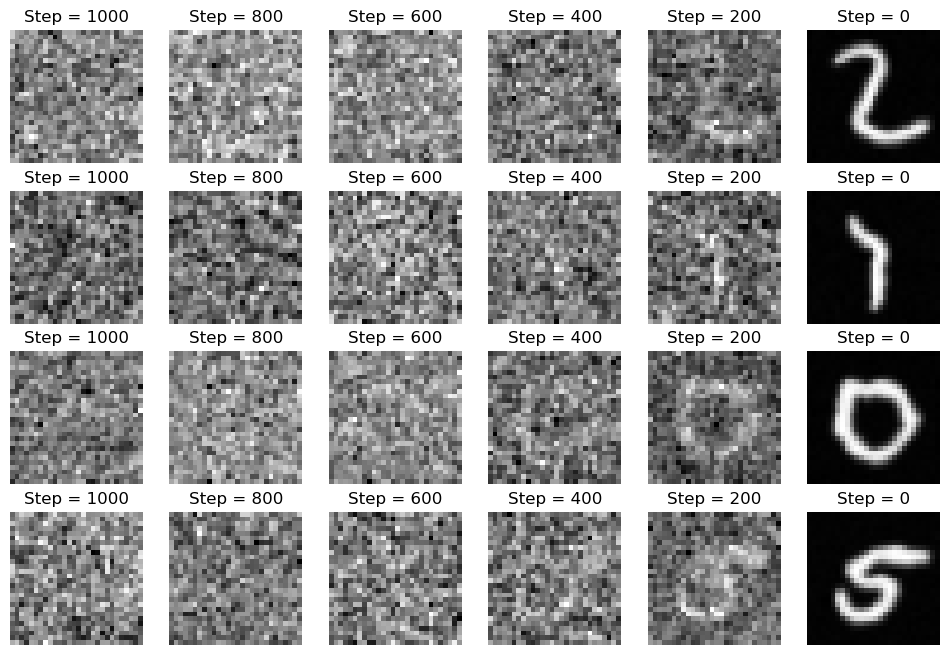

In [113]:
# Plot reverse process

num_fig = 4
steps = 200
num_steps = int(N/steps)+1

plt.figure(figsize=(2*num_steps, 2*num_fig))

for j in range(num_fig):
    k = 0
    for i in range(0, N+1, steps):
        plt.subplot(num_fig, num_steps, k + num_steps*j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
        plt.title('Step = {}'.format(N - i))   #第一幅图片标题
        plt.imshow(x_motion[j][i], cmap = "gray")      #绘制第一幅图片
        plt.axis("off")
        k = k+1
        # plt.pause(1)


# plt.show()   #显示窗口
# plt.savefig("SM_sample_8")   #显示窗口

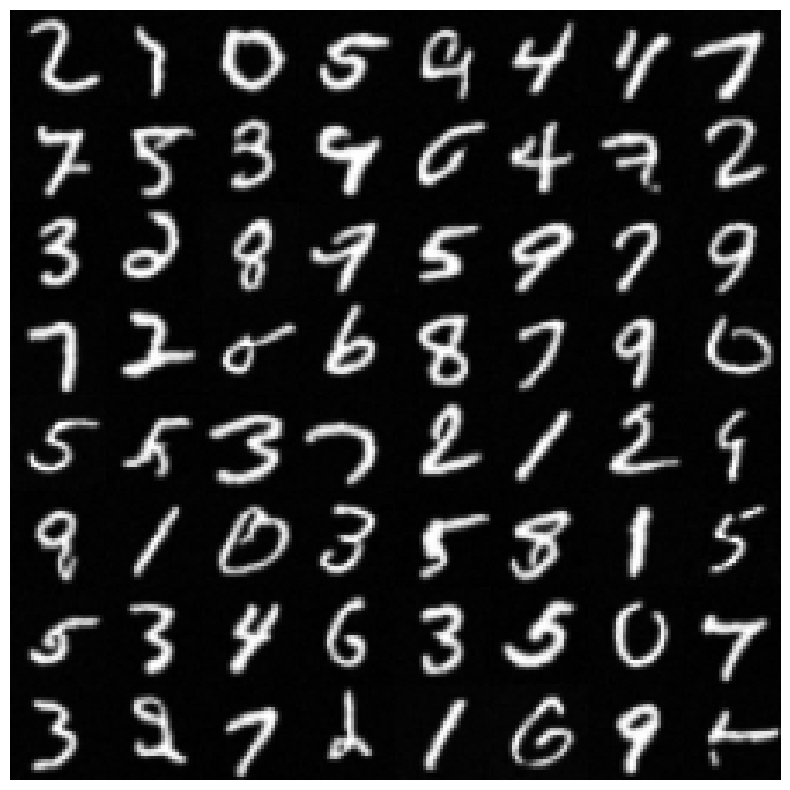

In [114]:
num_fig = 8
steps = int(N/5)
num_steps = int(N/steps)+1
# N=1000

fig = plt.figure(figsize=(num_fig, num_fig))

for j in range(num_fig**2):
    plt.subplot(num_fig, num_fig, j+1)     #将窗口分为两行两列四个子图，则可显示四幅图片
    # plt.title('Step = {}'.format(N - i))   #第一幅图片标题
    plt.imshow(x[j][-1], cmap = "gray")      #绘制第一幅图片
    plt.axis("off")
    k = k+1
    # plt.pause(1)

fig.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)

# plt.show()   #显示窗口
# plt.savefig("SM_sample_8")   #显示窗口